In [5]:
#!/usr/bin/python3

# ****************************************************************************
# Copyright(c) 2017 Intel Corporation. 
# License: MIT See LICENSE file in root directory.
# ****************************************************************************

# How to classify images using DNNs on Intel Neural Compute Stick (NCS)

import os
import sys
import numpy
import ntpath
import argparse
import skimage.io
import skimage.transform

import mvnc.mvncapi as mvnc

# Number of top prodictions to print
NUM_PREDICTIONS		= 2

# Variable to store commandline arguments
ARGS                = None

# ---- Step 1: Open the enumerated device and get a handle to it -------------

def open_ncs_device():

    # Look for enumerated NCS device(s); quit program if none found.
    devices = mvnc.enumerate_devices()
    if len( devices ) == 0:
        print( "No devices found" )
        quit()

    # Get a handle to the first enumerated device and open it
    device = mvnc.Device( devices[0] )
    device.open()

    return device

# ---- Step 2: Load a graph file onto the NCS device -------------------------

def load_graph( device ):


    # Read the graph file into a buffer
    with open( ARGS.graph, mode='rb' ) as f:
        blob = f.read()

    # Load the graph buffer into the NCS
    graph = mvnc.Graph( ARGS.graph )
    # Set up fifos
    fifo_in, fifo_out = graph.allocate_with_fifos( device, blob )

    return graph, fifo_in, fifo_out

# ---- Step 3: Pre-process the images ----------------------------------------

def pre_process_image():

    # Read & resize image [Image size is defined during training]
    img = skimage.io.imread( ARGS.image )
    img = skimage.transform.resize( img, ARGS.dim, preserve_range=True )

    # Convert RGB to BGR [skimage reads image in RGB, but Caffe uses BGR]
    if( ARGS.colormode == "BGR" ):
        img = img[:, :, ::-1]
        
    
    # Mean subtraction & scaling [A common technique used to center the data]
    img = ( img - ARGS.mean ) * ARGS.scale
    return img

# ---- Step 4: Read & print inference results from the NCS -------------------

def infer_image( graph, img, fifo_in, fifo_out ):


    # Load the labels file 
    labels =[ line.rstrip('\n') for line in 
                   open( ARGS.labels ) if line != 'classes\n'] 
    
    
    # The first inference takes an additional ~20ms due to memory 
    # initializations, so we make a 'dummy forward pass'.
    graph.queue_inference_with_fifo_elem( fifo_in, fifo_out, img.astype(numpy.float32), None )

    output, userobj = fifo_out.read_elem()

    print( "\n==  userobj   ===" )
    print(userobj)
    print( "\n==  output   ===" )
    print(output)
    
    # Load the image as an array
    graph.queue_inference_with_fifo_elem( fifo_in, fifo_out, img.astype(numpy.float32), None )

    # Get the results from NCS
    output, userobj = fifo_out.read_elem()

    # Sort the indices of top predictions
    order = output.argsort()[::-1][:NUM_PREDICTIONS]

    # Get execution time
    inference_time = graph.get_option( mvnc.GraphOption.RO_TIME_TAKEN )

    # Print the results
    print( "\n==============================================================" )
    print( "Top predictions for", ntpath.basename( ARGS.image ) )
    print( "Execution time: " + str( numpy.sum( inference_time ) ) + "ms" )
    print( "--------------------------------------------------------------" )
    for i in range( 0, NUM_PREDICTIONS ):
        print( "%3.1f%%\t" % (100.0 * output[ order[i] ] )
               + labels[ order[i] ] )
    print( "==============================================================" )

    # If a display is available, show the image on which inference was performed
    if 'DISPLAY' in os.environ:
        skimage.io.imshow( ARGS.image )
        skimage.io.show()

# ---- Step 5: Close/clean up fifos, graph, and device -------------------------

def clean_up(device, graph, fifo_in, fifo_out):
    fifo_in.destroy()
    fifo_out.destroy()
    graph.destroy()
    device.close()
    device.destroy()


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/mvnc/mvncapi.py:416: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  tensor = numpy.fromstring(tensor.raw, dtype=numpy.float32)



==  userobj   ===
None

==  output   ===
[0. 1.]

Top predictions for stest200.jpg
Execution time: 4424.1787ms
--------------------------------------------------------------
100.0%	n1 1:smo
0.0%	n0 0:nosmo


/usr/local/lib/python3.5/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


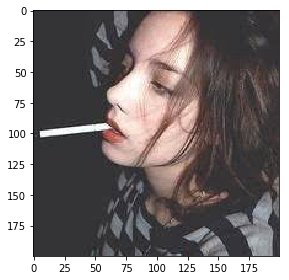

In [7]:
import argparse
import sys
sys.argv
def main():

    device = open_ncs_device()
    graph, fifo_in, fifo_out = load_graph( device )

    img = pre_process_image()
    infer_image( graph, img, fifo_in, fifo_out )
    clean_up(device, graph, fifo_in, fifo_out)

# ---- Define 'main' function as the entry point for this script -------------

if __name__ == '__main__':
     
    parser = argparse.ArgumentParser(
                         description="Image classifier using \
                         Intel® Movidius™ Neural Compute Stick." )
    
    #mvNCCompile  ./frozen_model_inception_resnet_v2_1218.pb -in=Placeholder_only -on=InceptionResnetV2/Logits/Predictions -o ./resnetv21219.graph
    #mvNCCompile  ./frozen_model_inception_resnet_v2_1218.pb -in=Placeholder_only -on=InceptionResnetV2/Logits/Predictions -o ./resnetv212192.graph -is 299 299    
    #mvNCCompile ./frozen_model_inception_resnet_v2_1218.pb  -in=Placeholder_only -on=InceptionResnetV2/Logits/Predictions -o ./grap
    parser.add_argument( '-g', '--graph', type=str,
                         default='./graph',
                         help="Absolute path to the neural network graph file." )

    parser.add_argument( '-i', '--image', type=str,
                         default='./stest200.jpg',
                         help="Absolute path to the image that needs to be inferred." )

    parser.add_argument( '-l', '--labels', type=str,
                         default='./labels.txt',
                         help="Absolute path to labels file." )
    
    parser.add_argument( '-M', '--mean', type=float,
                         nargs='+',
                         default=127.5,
                         help="',' delimited floating point values for image mean." )
    
    parser.add_argument( '-S', '--scale', type=float,
                         default=0.00789,
                         help="Absolute path to labels file." )

    parser.add_argument( '-D', '--dim', type=int,
                         nargs='+',
                         default=[299, 299],
                         help="Image dimensions. ex. -D 32 32" )

    parser.add_argument( '-c', '--colormode', type=str,
                         default="RGB",
                         help="RGB vs BGR color sequence. TensorFlow = RGB, Caffe = BGR" )
    ARGS = parser.parse_args(args=[])
    #ARGS = parser.parse_args()
    # https://blog.csdn.net/u012869752/article/details/72513141
    main()
# ==== End of file ====================================

In [3]:
! pwd

/home/cyril/work/work/AI/movidius


In [ ]:
###################強制轉換~原本nosmo 無法到299 299用以下CODE將原本image 轉成299 在丟給 tf.train.Example

import os 
import tensorflow as tf 
from PIL import Image  #注意Image,后面会用到
import matplotlib.pyplot as plt 
import numpy as np


size = 299, 299

classes={'nosmo','smo'} # 设定 2 类 smo ,nosmo

#writer= tf.python_io.TFRecordWriter("./nosmo.tfrecords") #要生成的文件

###################強制轉換~原本nosmo 無法到299 299用以下CODE 強轉
###################強制轉換~原本nosmo 無法到299 299用以下CODE 強轉

class_path='./im/'
cwd=class_path+'/out/' 

current = 0
for img_name in os.listdir(class_path): 
    img_path=class_path+img_name #每一个图片的地址
    
    img=Image.open(img_path)
    img=Image.open(img_path).convert('RGB')
    img= img.resize((299,299), Image.ANTIALIAS)
    ssstr=class_path+str(current)+'.jpg' #另存新圖
    #print(ssstr)
    img.save(ssstr)

    print(current)
    img_raw=img.tobytes()#将图片转化为二进制格式
    example = tf.train.Example(features=tf.train.Features(feature={
        "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[current])),
        'img_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw]))
    })) #example对象对label和image数据进行封装
    #writer.write(example.SerializeToString())  #序列化为字符串
    current += 1
#writer.close()


## This flowiing code can not be used infrence dut to scale of error!

In [4]:


#if __name__ == '__main__':

#    parser = argparse.ArgumentParser(
#                         description="Image classifier using \
#                         Intel® Movidius™ Neural Compute Stick." )
#
#    parser.add_argument( '-g', '--graph', type=str,
#                         default='../../caffe/GoogLeNet/graph',
#                         help="Absolute path to the neural network graph file." )
#
#    parser.add_argument( '-i', '--image', type=str,
#                         default='../../data/images/cat.jpg',
#                         help="Absolute path to the image that needs to be inferred." )
#
#    parser.add_argument( '-l', '--labels', type=str,
#                         default='../../data/ilsvrc12/synset_words.txt',
#                         help="Absolute path to labels file." )
#
#    parser.add_argument( '-M', '--mean', type=float,
#                         nargs='+',
#                         default=[104.00698793, 116.66876762, 122.67891434],
#                         help="',' delimited floating point values for image mean." )
#
#    parser.add_argument( '-S', '--scale', type=float,
#                         default=1,
#                         help="Absolute path to labels file." )
#
#    parser.add_argument( '-D', '--dim', type=int,
#                         nargs='+',
#                         default=[224, 224],
#                         help="Image dimensions. ex. -D 224 224" )
#
#    parser.add_argument( '-c', '--colormode', type=str,
#                         default="BGR",
#                         help="RGB vs BGR color sequence. TensorFlow = RGB, Caffe = BGR" )
#
#
#    ARGS = parser.parse_args()
#
#    main()

# ==== End of file ===========================================================
